<a href="https://colab.research.google.com/github/laraselinseyahi/CS224N-Spring2024-DFP-Student-Handout/blob/main/CS230_Project_LaraSelinSeyahi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/retino
%ls

/content/drive/.shortcut-targets-by-id/10Dhnw5XgywCVtNVsUSRW7EGrdxvuExf3/retino
test/  train/  valid/


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import os


# Data Pre-processing


In [ ]:
train_dir = 'train/'
val_dir = 'valid/'
test_dir = 'test/'

# Define image parameters
img_height = 224
img_width = 224
batch_size = 32

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Important for evaluation; keep order consistent
)

Found 2096 files belonging to 2 classes.
Found 561 files belonging to 2 classes.
Found 231 files belonging to 2 classes.


In [ ]:
# helps keep memory in cache after it's been loaded from the disk
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
normalization_layer = tf.keras.applications.resnet.preprocess_input

In [ ]:
data_augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

def data_augmentation_layer_function(inputs):
    return data_augmentation_layer(inputs)

# Apply the data augmentation to each element in the dataset
def apply_data_augmentation(image, label):
    # Apply augmentation only to the image (not the label)
    augmented_image = data_augmentation_layer(image)
    return augmented_image, label

# Define the normalization layer
def normalization_layer(inputs):
    return tf.keras.applications.resnet.preprocess_input(inputs)

# ResNet-50


In [ ]:
# RESNET

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_model.layers:
  layer.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))  # Define the input shape
x = data_augmentation_layer(inputs)  # Apply data augmentation
x = normalization_layer(x)  # Apply normalization (preprocessing)
x = resnet_model(x)  # Pass through the base ResNet model
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling layer
outputs = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the model
model = models.Model(inputs, outputs)

base_learning_rate = 0.001

# since this is binary classification, loss is BCE
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train with frozen base model layers
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5


KeyboardInterrupt: 

In [ ]:
# RESNET Experimenting

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_model.layers:
  layer.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))  # Define the input shape
x = data_augmentation_layer(inputs)  # Apply data augmentation
x = normalization_layer(x)  # Apply normalization (preprocessing)
x = resnet_model(x)  # Pass through the base ResNet model
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling layer
x = layers.Dense(128, activation='relu')(x)  # Dense layer
x = layers.Dropout(0.5)(x)  # Dropout for regularization
outputs = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification # try with having on this dense layer! then add one by one

# Create the model
model = models.Model(inputs, outputs)

base_learning_rate = 0.001

# since this is binary classification, loss is BCE
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train with frozen base model layers
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
<GlobalAveragePooling2D name=avg_pool, built=True>
<Dense name=predictions, built=True>
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.8360 - loss: 0.3932 - val_accuracy: 0.9216 - val_loss: 0.1681
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 175ms/step - accuracy: 0.9369 - loss: 0.1711 - val_accuracy: 0.9323 - val_loss: 0.1808
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.9379 - loss: 0.1846 - val_accuracy: 0.9447 - val_loss: 0.1372
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.9495 - loss: 0.1507 - val_accuracy: 0.9572 - val_loss: 0.1247
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.9567 - loss: 0.1368 - val_accuracy: 0.9483 - val_loss: 0.1164
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32) tf.Tensor(
[[2.7780848e-02]
 [7.4290633e-06]
 [7.2573428e-04]
 [1.9

In [ ]:
# RESNET (Training 50 epochs and unfroze last 10 layers)

# delete top layer (include_top = false, make other layers non-trainable)
resnet_model_top = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
for layer in resnet_model_top.layers[-2:]:
  print(layer)


# delete top layer (include_top = false, make other layers non-trainable)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_model.layers[:-10]:
  layer.trainable = False

#x = normalization_layer(x)

# x = train_ds.map(apply_data_augmentation)
# x = normalization_layer(train_ds)

# on top of the base model, add layers for binary classification
# Build the model
inputs = tf.keras.Input(shape=(224, 224, 3))  # Define the input shape
x = data_augmentation_layer(inputs)  # Apply data augmentation
x = normalization_layer(x)  # Apply normalization (preprocessing)
x = resnet_model(x)  # Pass through the base ResNet model
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling layer # TRY OUT different ways!! # hypothesis (ex: same performance can be achieved with less layers, reduce the number of layers)
x = layers.Dense(128, activation='relu')(x)  # Dense layer
outputs = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification # try with having on this dense layer! then add one by one

# Create the model
model = models.Model(inputs, outputs)

base_learning_rate = 0.001

# since this is binary classification, loss is BCE
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train with frozen base model layers
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50  # Start with a few epochs
)


# try not fine-tuning the model on the dataset below 94 (both accuracies)
# usually you have a hypothesis about the architecture

<GlobalAveragePooling2D name=avg_pool, built=True>
<Dense name=predictions, built=True>
Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 297ms/step - accuracy: 0.8912 - loss: 0.2465 - val_accuracy: 0.9412 - val_loss: 0.8257
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.9646 - loss: 0.1024 - val_accuracy: 0.9091 - val_loss: 0.5204
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9677 - loss: 0.0976 - val_accuracy: 0.9269 - val_loss: 0.3669
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 0.9779 - loss: 0.0789 - val_accuracy: 0.8574 - val_loss: 0.3205
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.9759 - loss: 0.0717 - val_accuracy: 0.9109 - val_loss: 0.2580
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 238ms/step - accuracy: 0.9713 - loss: 0.0850 - val_accuracy: 0.9715 - val_loss: 0.1195
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 0.9771 - loss: 0.0742 - val_accuracy: 0.9715 - val_loss: 0.0813
Epoch 8/5

50


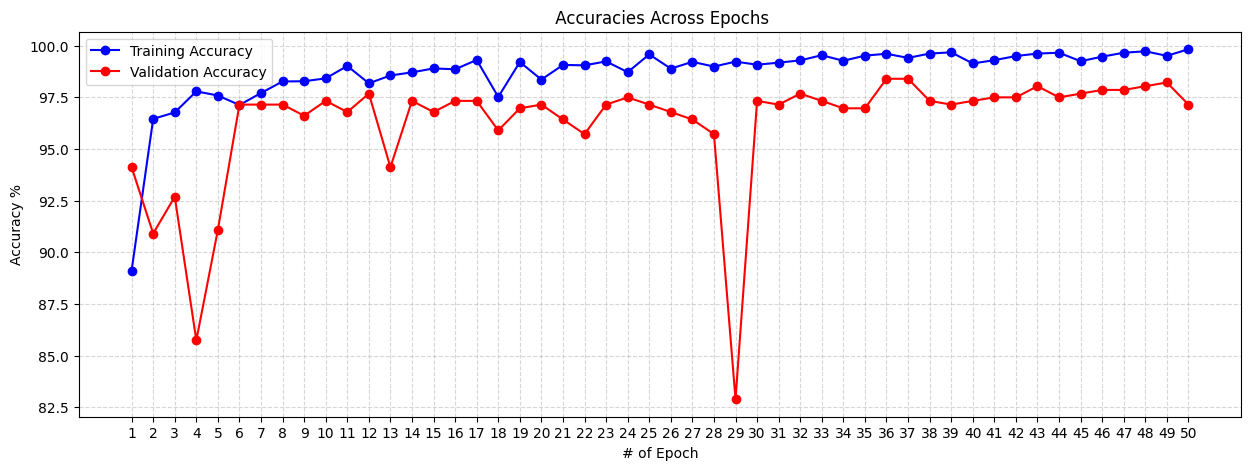

In [ ]:
import matplotlib.pyplot as plt

# Example data
x = [i for i in range(1, 51)]  # X-axis values
y = [0.8912, 0.9646, 0.9677, 0.9779, 0.9759, 0.9713, 0.9771, 0.9827, 0.9828, 0.9842, 0.9902, 0.9818, 0.9856, 0.9871, 0.9890, 0.9886, 0.9931, 0.9752, 0.9921, 0.9836, 0.9907, 0.9905, 0.9924, 0.9872, 0.9958, 0.9889, 0.9922, 0.9899, 0.9923, 0.9908, 0.9918, 0.9929, 0.9954, 0.9927, 0.9952, 0.9961, 0.9941, 0.9962, 0.9968, 0.9914, 0.9930, 0.9950, 0.9962, 0.9966, 0.9925, 0.9947, 0.9966, 0.9973, 0.9951, 0.9983]  # Y-axis values
print(len(y))
y = list(map(lambda x: x * 100, y))

plt.figure(figsize=(15, 5))  # Width = 15, Height = 5
val_acc = [0.9412, 0.9091, 0.9269, 0.8574, 0.9109, 0.9715, 0.9715, 0.9715, 0.9661, 0.9733, 0.9679, 0.9768, 0.9412, 0.9733, 0.9679, 0.9733, 0.9733, 0.9590, 0.9697, 0.9715, 0.9643, 0.9572, 0.9715, 0.9750, 0.9715, 0.9679, 0.9643, 0.9572, 0.8289, 0.9733, 0.9715, 0.9768, 0.9733, 0.9697, 0.9697, 0.9840, 0.9840, 0.9733, 0.9715, 0.9733, 0.9750, 0.9750, 0.9804, 0.9750, 0.9768, 0.9786, 0.9786, 0.9804, 0.9822, 0.9715]
val_acc = list(map(lambda x: x * 100, val_acc))

# Create the plot
plt.plot(x, y, label="Training Accuracy", color="blue", marker="o")
plt.plot(x, val_acc, label="Validation Accuracy", color="red", marker="o")

# Add labels and title
plt.xlabel("# of Epoch")
plt.ylabel("Accuracy %")
plt.title(" Accuracies Across Epochs")

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(ticks=range(1, 51, 1))  # Show a tick every 2 numbers

# Add a legend
plt.legend()

# Show the plot
plt.show()


# AlexNet

In [ ]:
# ALEXNET Baseline Model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets

from torch.utils.data import DataLoader

# Define transformations (resizing, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize(256),       # Resize the image to 256x256
    transforms.CenterCrop(224),   # Crop the center of the image to 224x224
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for AlexNet
])

# Load dataset (for example, using ImageFolder)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load dataset (for example, using ImageFolder)
valid_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

#should I instead write it from scratch with tensor flow?

# Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)

# Freeze early layers (optional)
for param in alexnet.features.parameters():
    param.requires_grad = False

# Modify the classifier for binary classification
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 2) # should I add av pooling, relu and sigmoid?

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

# Training loop (simplified)
num_epochs = 5
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = alexnet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Validation phase
    alexnet.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = alexnet(images)
            loss = criterion(outputs, labels)

            # Update validation metrics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


# transformers


Epoch 1/5, Loss: 0.4041, Accuracy: 89.65%
Validation Loss: 0.1316, Validation Accuracy: 95.54%
Epoch 2/5, Loss: 0.1735, Accuracy: 94.51%
Validation Loss: 0.2905, Validation Accuracy: 94.47%
Epoch 3/5, Loss: 0.1408, Accuracy: 96.23%
Validation Loss: 0.2119, Validation Accuracy: 93.58%
Epoch 4/5, Loss: 0.1875, Accuracy: 95.18%
Validation Loss: 0.2882, Validation Accuracy: 87.88%
Epoch 5/5, Loss: 0.2045, Accuracy: 95.32%
Validation Loss: 0.1728, Validation Accuracy: 94.65%


In [ ]:
# ALEXNET Experiments
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets

from torch.utils.data import DataLoader

# Define transformations (resizing, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize(256),       # Resize the image to 256x256
    transforms.CenterCrop(224),   # Crop the center of the image to 224x224
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for AlexNet
])

# Load dataset (for example, using ImageFolder)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load dataset (for example, using ImageFolder)
valid_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

#should I instead write it from scratch with tensor flow?

# Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)

# Freeze early layers (optional)
for param in alexnet.features.parameters():
    param.requires_grad = False

# Modify the classifier
alexnet.classifier = nn.Sequential(
    *list(alexnet.classifier.children())[:-1],  # Remove the last layer
    nn.Linear(alexnet.classifier[6].in_features, 128),  # Add dense layer
    nn.ReLU(),
    nn.Linear(128, 2)  # Final output layer for 2 classes
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

# Training loop (simplified)
num_epochs = 5
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = alexnet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Validation phase
    alexnet.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = alexnet(images)
            loss = criterion(outputs, labels)

            # Update validation metrics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/5, Loss: 0.3323, Accuracy: 89.12%
Validation Loss: 0.1946, Validation Accuracy: 94.83%
Epoch 2/5, Loss: 0.1559, Accuracy: 95.13%
Validation Loss: 0.1372, Validation Accuracy: 95.72%
Epoch 3/5, Loss: 0.1215, Accuracy: 96.52%
Validation Loss: 0.1419, Validation Accuracy: 95.54%
Epoch 4/5, Loss: 0.1134, Accuracy: 96.23%
Validation Loss: 0.1209, Validation Accuracy: 95.90%
Epoch 5/5, Loss: 0.0810, Accuracy: 97.61%
Validation Loss: 0.1293, Validation Accuracy: 96.26%


In [ ]:
# ALEXNET
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets

from torch.utils.data import DataLoader

# Define transformations (resizing, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize(256),       # Resize the image to 256x256
    transforms.CenterCrop(224),   # Crop the center of the image to 224x224
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for AlexNet
])

# Load dataset (for example, using ImageFolder)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load dataset (for example, using ImageFolder)
valid_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

#should I instead write it from scratch with tensor flow?

# Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)

# Freeze early layers (optional)
for param in alexnet.features.parameters():
    param.requires_grad = False

# Modify the classifier
alexnet.classifier = nn.Sequential(
    *list(alexnet.classifier.children())[:-1],  # Remove the last layer
    nn.Linear(alexnet.classifier[6].in_features, 128),  # Add dense layer
    nn.ReLU(),  # ReLU activation
    nn.Linear(128, 128),  # Add dense layer
    nn.ReLU(),  # ReLU activation
    nn.Linear(128, 2)  # Final output layer for 2 classes
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

# Training loop (simplified)
num_epochs = 5
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = alexnet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Validation phase
    alexnet.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = alexnet(images)
            loss = criterion(outputs, labels)

            # Update validation metrics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 121MB/s]


Epoch 1/5, Loss: 0.3013, Accuracy: 90.36%
Validation Loss: 0.1655, Validation Accuracy: 95.72%
Epoch 2/5, Loss: 0.1501, Accuracy: 95.71%
Validation Loss: 0.1715, Validation Accuracy: 94.65%
Epoch 3/5, Loss: 0.1176, Accuracy: 96.47%
Validation Loss: 0.1648, Validation Accuracy: 95.54%
Epoch 4/5, Loss: 0.1010, Accuracy: 97.14%
Validation Loss: 0.1637, Validation Accuracy: 95.01%
Epoch 5/5, Loss: 0.0926, Accuracy: 96.99%
Validation Loss: 0.0996, Validation Accuracy: 95.72%


In [ ]:
# ALEXNET
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets

from torch.utils.data import DataLoader

# Defining transformations (resizing, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize(256),       # Resize the image to 256x256
    transforms.CenterCrop(224),   # Crop the center of the image to 224x224
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for AlexNet
])

# Load dataset (for example, using ImageFolder)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load dataset (for example, using ImageFolder)
valid_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)

# Freeze early layers (optional)
for param in alexnet.features.parameters():
    param.requires_grad = False

# Modify the classifier
alexnet.classifier = nn.Sequential(
    *list(alexnet.classifier.children())[:-1],  # Remove the last layer
    nn.Linear(alexnet.classifier[6].in_features, 128),  # Add dense layer
    nn.ReLU(),  # ReLU activation
    nn.Dropout(p=0.5),  # Dropout with a probability of 0.5
    nn.Linear(128, 2)  # Final output layer for 2 classes
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

# Training loop (simplified)
num_epochs = 5
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = alexnet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Validation phase
    alexnet.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = alexnet(images)
            loss = criterion(outputs, labels)

            # Update validation metrics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/5, Loss: 0.3318, Accuracy: 88.93%
Validation Loss: 0.2169, Validation Accuracy: 93.23%
Epoch 2/5, Loss: 0.1978, Accuracy: 94.04%
Validation Loss: 0.1112, Validation Accuracy: 96.08%
Epoch 3/5, Loss: 0.1661, Accuracy: 95.66%
Validation Loss: 0.1137, Validation Accuracy: 95.90%
Epoch 4/5, Loss: 0.1237, Accuracy: 95.90%
Validation Loss: 0.1822, Validation Accuracy: 96.26%
Epoch 5/5, Loss: 0.1193, Accuracy: 96.90%
Validation Loss: 0.1705, Validation Accuracy: 96.08%


In [ ]:
# ALEXNET !!!
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets

from torch.utils.data import DataLoader

# Define transformations (resizing, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize(256),       # Resize the image to 256x256
    transforms.CenterCrop(224),   # Crop the center of the image to 224x224
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for AlexNet
])

# Load dataset (for example, using ImageFolder)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load dataset (for example, using ImageFolder)
valid_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)

# Freeze early layers (optional)
for param in alexnet.features.parameters():
    param.requires_grad = False

# Modify the classifier
alexnet.classifier = nn.Sequential(
    *list(alexnet.classifier.children())[:-1],  # Remove the last layer
    nn.Linear(alexnet.classifier[6].in_features, 256),  # Add dense layer
    nn.ReLU(),  # ReLU activation
    nn.Linear(256, 2)  # Final output layer for 2 classes
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

# Training loop (simplified)
num_epochs = 5
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = alexnet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Validation phase
    alexnet.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = alexnet(images)
            loss = criterion(outputs, labels)

            # Update validation metrics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/5, Loss: 0.3242, Accuracy: 89.89%
Validation Loss: 0.1377, Validation Accuracy: 95.01%
Epoch 2/5, Loss: 0.1443, Accuracy: 96.04%
Validation Loss: 0.1023, Validation Accuracy: 95.90%
Epoch 3/5, Loss: 0.1324, Accuracy: 96.04%
Validation Loss: 0.2942, Validation Accuracy: 87.34%
Epoch 4/5, Loss: 0.1119, Accuracy: 96.23%
Validation Loss: 0.0949, Validation Accuracy: 96.79%
Epoch 5/5, Loss: 0.0941, Accuracy: 97.14%
Validation Loss: 0.3270, Validation Accuracy: 93.40%


# InceptionNet

In [ ]:
# INCEPTIONNET

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

# Load InceptionNet without the top layer
inceptionnet_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in inceptionnet_model.layers:
  layer.trainable = False

model = models.Sequential([
    # Apply data augmentation to the input
    data_augmentation,
    # Resize the images to 299x299
    layers.Lambda(lambda x: tf.image.resize(x, (299, 299))),
    # Preprocess the image data using InceptionV3 preprocessing
    layers.Lambda(lambda x: tf.keras.applications.inception_v3.preprocess_input(x)), # normalization

    inceptionnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])


# train_ds = train_ds.map(lambda x, y: (tf.keras.applications.inception_v3.preprocess_input(data_augmentation(x)), y))

base_learning_rate = 0.001

# sincd this is binary classification, loss is BCE
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train with frozen base model layers
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # Start with a few epochs
)



Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 302ms/step - accuracy: 0.7943 - loss: 0.4219 - val_accuracy: 0.8253 - val_loss: 0.3754
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9031 - loss: 0.2706 - val_accuracy: 0.8859 - val_loss: 0.2955
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.9264 - loss: 0.2237 - val_accuracy: 0.8841 - val_loss: 0.2919
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.9160 - loss: 0.2358 - val_accuracy: 0.7968 - val_loss: 0.4203
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9235 - loss: 0.2274 - val_accuracy: 0.8859 - val_loss: 0.2696


In [ ]:
# INCEPTIONNET !!

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

# Load InceptionNet without the top layer
inceptionnet_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in inceptionnet_model.layers:
  layer.trainable = False

model = models.Sequential([
    layers.Input(shape=(299, 299, 3)),  # Input can have dynamic size; adjust as needed

    # Apply data augmentation to the input
    data_augmentation,
    # Resize the images to 299x299
    layers.Lambda(lambda x: tf.image.resize(x, (299, 299))),
    # Preprocess the image data using InceptionV3 preprocessing
    layers.Lambda(lambda x: tf.keras.applications.inception_v3.preprocess_input(x)), # normalization

    inceptionnet_model,
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])


# train_ds = train_ds.map(lambda x, y: (tf.keras.applications.inception_v3.preprocess_input(data_augmentation(x)), y))

base_learning_rate = 0.001

# sincd this is binary classification, loss is BCE
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train with frozen base model layers
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # Start with a few epochs
)


Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 320ms/step - accuracy: 0.7311 - loss: 0.5305 - val_accuracy: 0.7308 - val_loss: 0.5410
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - accuracy: 0.9158 - loss: 0.2312 - val_accuracy: 0.8021 - val_loss: 0.4352
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.9431 - loss: 0.1816 - val_accuracy: 0.9340 - val_loss: 0.1851
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - accuracy: 0.9508 - loss: 0.1566 - val_accuracy: 0.9376 - val_loss: 0.1789
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.9451 - loss: 0.1481 - val_accuracy: 0.9127 - val_loss: 0.2124


In [ ]:
# INCEPTIONNET

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

# Load InceptionNet without the top layer
inceptionnet_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in inceptionnet_model.layers:
  layer.trainable = False

model = models.Sequential([
    layers.Input(shape=(299, 299, 3)),  # Input can have dynamic size; adjust as needed

    # Apply data augmentation to the input
    data_augmentation,
    # Resize the images to 299x299
    layers.Lambda(lambda x: tf.image.resize(x, (299, 299))),
    # Preprocess the image data using InceptionV3 preprocessing
    layers.Lambda(lambda x: tf.keras.applications.inception_v3.preprocess_input(x)), # normalization

    inceptionnet_model,
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

base_learning_rate = 0.001

# sincd this is binary classification, loss is BCE
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train with frozen base model layers
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # Start with a few epochs
)

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - accuracy: 0.7936 - loss: 0.4786 - val_accuracy: 0.7986 - val_loss: 0.4268
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.9270 - loss: 0.2386 - val_accuracy: 0.7540 - val_loss: 0.4674
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.9195 - loss: 0.2321 - val_accuracy: 0.8396 - val_loss: 0.3579
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.9423 - loss: 0.1871 - val_accuracy: 0.8253 - val_loss: 0.3686
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.9429 - loss: 0.1961 - val_accuracy: 0.8574 - val_loss: 0.3106


In [ ]:
# INCEPTIONNET

# Load InceptionNet without the top layer
inceptionnet_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in inceptionnet_model.layers:
  layer.trainable = False

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

model = models.Sequential([
    layers.Input(shape=(299, 299, 3)),  # Input can have dynamic size; adjust as needed
    # Apply data augmentation to the input
    data_augmentation,    # Resize the images to 299x299
    layers.Lambda(lambda x: tf.image.resize(x, (299, 299))),
    # Preprocess the image data using InceptionV3 preprocessing
    layers.Lambda(lambda x: tf.keras.applications.inception_v3.preprocess_input(x)), # normalization
    inceptionnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# train_ds = train_ds.map(lambda x, y: (tf.keras.applications.inception_v3.preprocess_input(data_augmentation(x)), y))

base_learning_rate = 0.001

# sincd this is binary classification, loss is BCE
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train with frozen base model layers
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 318ms/step - accuracy: 0.7465 - loss: 0.5215 - val_accuracy: 0.7790 - val_loss: 0.4494
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.9303 - loss: 0.2457 - val_accuracy: 0.8271 - val_loss: 0.3737
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.9369 - loss: 0.2087 - val_accuracy: 0.8342 - val_loss: 0.3483
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 304ms/step - accuracy: 0.9471 - loss: 0.1667 - val_accuracy: 0.8324 - val_loss: 0.3428
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - accuracy: 0.9540 - loss: 0.1602 - val_accuracy: 0.8414 - val_loss: 0.3245
